# **A Neural Algorithm of Artistic Style**

Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. arXiv preprint arXiv:1508.06576.

Ref.

*https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko*

In [ ]:
!pip install -q imageio

In [ ]:
import tensorflow as tf

import glob
import imageio
import PIL.Image

import IPython.display as display
import numpy as np

from matplotlib import pyplot as plt

tf.__version__

'2.4.1'

## **Get Images**

In [ ]:
def tensor_to_image(tensor, save_name = None):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    img = PIL.Image.fromarray(tensor)
    if save_name != None:
        img.save(f"{save_name}.png")
    return img

In [ ]:
content_path = tf.keras.utils.get_file(
    "YellowLabradorLooking_new.jpg", 
    "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
)

style_path = tf.keras.utils.get_file(
    "StarryNight_VanGogh.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/909px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg?download",
)

319488/313233 [==============================] - 0s 0us/step


In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [ ]:
def imshow(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

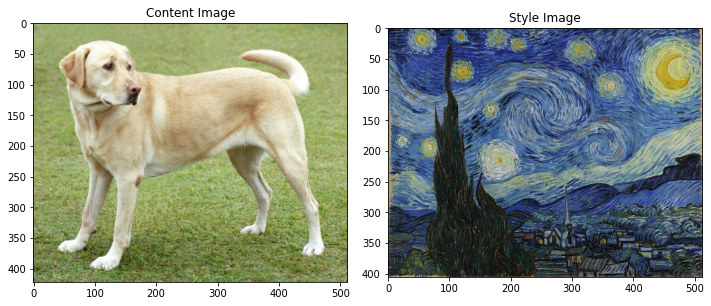

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize = (10, 5), facecolor = "white")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.tight_layout()
plt.show()

## **Get Model**

In [ ]:
vgg = tf.keras.applications.VGG19(
    include_top = True, 
    weights = "imagenet",
    # pooling = "avg",
)

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
content_layers = ["block5_conv2"] 

style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1", 
                "block4_conv1", 
                "block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## **Build Model**

In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    return tf.keras.Model(
        inputs = [vgg.input], 
        outputs = outputs
    )

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(f"  Shape: {output.numpy().shape}")
    print(f"  Min: {output.numpy().min():.4f}")
    print(f"  Max: {output.numpy().max():.4f}")
    print(f"  Std: {output.numpy().mean():.4f}")
    print()

block1_conv1
  Shape: (1, 405, 512, 64)
  Min: 0.0000
  Max: 672.0403
  Std: 24.1721

block2_conv1
  Shape: (1, 202, 256, 128)
  Min: 0.0000
  Max: 2986.9609
  Std: 150.2145

block3_conv1
  Shape: (1, 101, 128, 256)
  Min: 0.0000
  Max: 7542.7319
  Std: 146.0854

block4_conv1
  Shape: (1, 50, 64, 512)
  Min: 0.0000
  Max: 17030.1523
  Std: 568.7065

block5_conv1
  Shape: (1, 25, 32, 512)
  Min: 0.0000
  Max: 4112.1680
  Std: 49.2011



## **Calculate Gram Matrix**

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

## **Style & Content Model**

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name : value 
                        for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

        ## Return outputs as dictionary format.
        return {"content": content_dict, "style": style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print("Style:")
for name, output in sorted(results["style"].items()):
    print("name")
    print(f"  Shape: {output.numpy().shape}")
    print(f"  Min: {output.numpy().min():.4f}")
    print(f"  Max: {output.numpy().max():.4f}")
    print(f"  Std: {output.numpy().mean():.4f}")
    print()


print("Content:")    
for name, output in sorted(results["content"].items()):
    print("  name")
    print(f"  Shape: {output.numpy().shape}")
    print(f"  Min: {output.numpy().min():.4f}")
    print(f"  Max: {output.numpy().max():.4f}")
    print(f"  Std: {output.numpy().mean():.4f}")
    print()

Style:
name
  Shape: (1, 64, 64)
  Min: 0.0055
  Max: 28014.5566
  Std: 263.7902

name
  Shape: (1, 128, 128)
  Min: 0.0000
  Max: 61479.4961
  Std: 9100.9492

name
  Shape: (1, 256, 256)
  Min: 0.0000
  Max: 545623.4375
  Std: 7660.9761

name
  Shape: (1, 512, 512)
  Min: 0.0000
  Max: 4320502.0000
  Std: 134288.8438

name
  Shape: (1, 512, 512)
  Min: 0.0000
  Max: 110005.3672
  Std: 1487.0378

Content:
  name
  Shape: (1, 26, 32, 512)
  Min: 0.0000
  Max: 2410.8796
  Std: 13.7641



## **Gradient Descent**

In [ ]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

In [ ]:
style_weight = 1e-2
content_weight = 1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

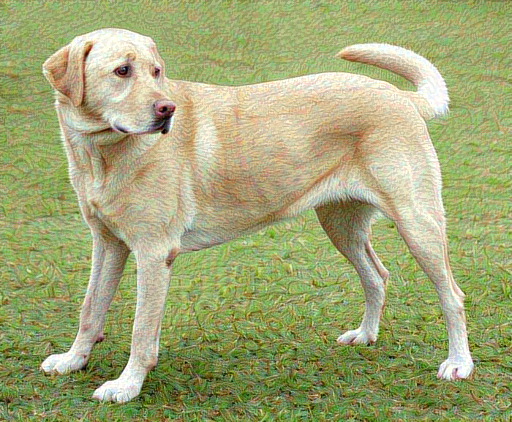

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

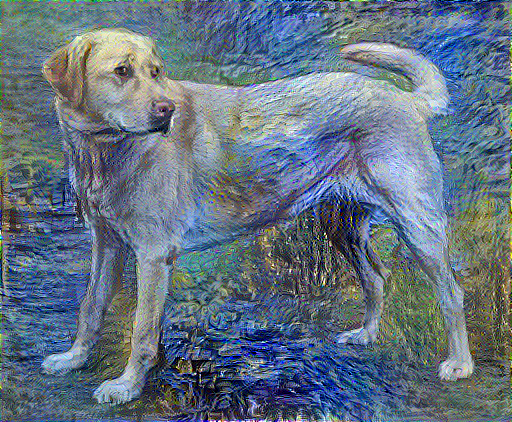

Training Step: 1000
Total Triaining Time: 20.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait = True)
    display.display(tensor_to_image(image))
    print(f"Training Step: {step:<3d}")

end = time.time()
print(f"Total Triaining Time: {end - start:.1f}")

## **Total Variation Loss**

In [ ]:
total_variation_weight = 30

In [ ]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

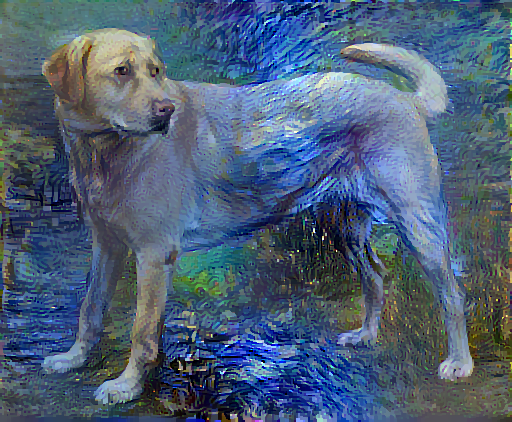

Training Step: 2000
Total Triaining Time: 47.3


In [ ]:
import time
start = time.time()

epochs = 40
steps_per_epoch = 50

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait = True)
    display.display(tensor_to_image(image, save_name = f"epoch{n:02d}"))
    print(f"Training Step: {step:04d}")

end = time.time()
print(f"Total Triaining Time: {end - start:.1f}")

## **Save Animate File**

In [ ]:
anim_file = "style_transfer.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("epoch*.png")
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6, 2, 0, ""):
    display.Image(filename = anim_file)

In [ ]:
try:
     from google.colab import files
except ImportError:
     pass
else:
     files.download(anim_file)